### As the first step all neccessary libraries will be imported; this list will be updated as we are going forward

In [1205]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble, model_selection
import seaborn as sns
import numpy as np
from collections import Counter

In [1206]:
trData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
data_list = [trData, testData]
trData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Cleaning
## The columns which are not numeric will be converted to numeric and the columns with too many NaNs will be removed (e.g., the Cabin)

In [1207]:
print("Total number of samples in train set is:", len(trData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(trData.isnull().sum())
print("*"*70)
print("Total number of samples in test set is:", len(testData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(testData.isnull().sum())

Total number of samples in train set is: 891
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
**********************************************************************
Total number of samples in test set is: 418
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [1208]:
for data in data_list:
    #data['Age'].fillna(trData['Age'].median(), inplace = True)
    data['Embarked'].fillna(trData['Embarked'].mode()[0], inplace = True)

In [1209]:
print("Total number of samples in train set is:", len(trData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(trData.isnull().sum())
print("*"*70)
print("Total number of samples in test set is:", len(testData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(testData.isnull().sum())

Total number of samples in train set is: 891
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
**********************************************************************
Total number of samples in test set is: 418
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [1210]:
combinedData = pd.concat(objs=[trData, testData], axis=0).reset_index(drop=True)

In [1211]:
PclassVsFare = combinedData[['Pclass','Fare']].groupby(['Pclass'], as_index = False).mean()
PclassVsFare

,Pclass,Fare
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [1212]:
testData['Pclass'][testData['Fare'].isnull()] 

152    3
Name: Pclass, dtype: int64

In [1213]:
# The passenger with missing class has a Pclass of 3 whose average Fare is 13.67 
testData['Fare'].fillna(PclassVsFare.loc[2,'Fare'], inplace = True);

In [1214]:
for data in data_list:
    data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
testData.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [1215]:
testData['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Dona        1
Ms          1
Name: Title, dtype: int64

In [1216]:
trData['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Mme               1
Lady              1
Jonkheer          1
Ms                1
Don               1
the Countess      1
Capt              1
Sir               1
Name: Title, dtype: int64

In [1217]:
for data in data_list:
    data['Title'] = data['Title'].replace(['Lady', 'Sir', 'the Countess'], 'Royal')
    data['Title'] = data['Title'].replace(['Ms', 'Mlle'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    data['Title'] = data['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')

In [1218]:
trData['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       20
Royal       3
Name: Title, dtype: int64

In [1219]:
testData['Title'].value_counts()

Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: Title, dtype: int64

In [1220]:
#min_val = 10
#title_names = (trData['Title'].value_counts() < min_val)
#trData['Title'] = trData['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [1221]:
combinedData = pd.concat(objs=[trData, testData], axis=0).reset_index(drop=True)

In [1222]:
title_vs_age = combinedData[['Title', 'Age']].groupby(['Title'], as_index = False).mean()
title_vs_age

,Title,Age
0,Master,5.482642
1,Miss,21.824366
2,Mr,32.252151
3,Mrs,36.918129
4,Rare,45.400000
5,Royal,43.333333


In [1223]:
title_vs_age.loc[title_vs_age['Title'] == 'Master', 'Age'][0]

5.4826415094339627

In [1224]:
# temp_array = []
# for data in data_list:
#     for i in range(len(data)):
#         if np.isnan(data['Age'][i]):
#             colVec = (data['Title'] == data['Title'][i]) & (data['Embarked'] == data['Embarked'][i]) & (data['Pclass'] == data['Pclass'][i]) 
#             temp_array.append(data.loc[colVec, 'Age'].mean())
#         else:
#             temp_array.append(data['Age'][i])
#     data['Age'] = temp_array
#     temp_array = []

In [1225]:
for i in range(0, len(title_vs_age)):
    title_temp = title_vs_age.loc[i]['Title']
    trData.loc[trData['Age'].isnull() & (trData['Title'] == title_temp), 'Age'] = title_vs_age.loc[title_vs_age['Title'] == title_temp, 'Age'][i]
    testData.loc[testData['Age'].isnull() & (testData['Title'] == title_temp), 'Age'] = title_vs_age.loc[title_vs_age['Title'] == title_temp, 'Age'][i]

### Cabin code; missing cabin code is converted to 0, and existing ones converted to 1

In [1226]:
for data in data_list:
    data['CabinCode'] = (data['Cabin'].notnull()) * 1

## Transfer categorial values to discrete values

In [1227]:
trData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinCode
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0


In [1228]:
trData['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare', 'Royal'], dtype=object)

### Define the age bins and fare bins

In [1229]:
age_bins = [0, 12, 19, 25, 35, 60, np.inf]
age_labels = ['Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
trData['AgeGroup'] = pd.cut(trData["Age"], age_bins, labels = age_labels)
testData['AgeGroup'] = pd.cut(testData["Age"], age_bins, labels = age_labels)

In [1230]:
trData['AgeGroup'].value_counts()

Young Adult    315
Adult          213
Student        173
Teenager        95
Child           73
Senior          22
Name: AgeGroup, dtype: int64

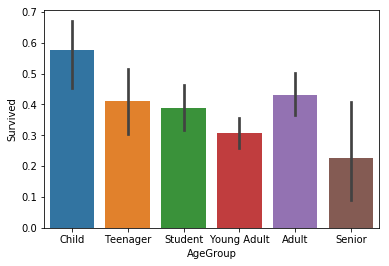

In [1231]:
sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData)
plt.show()

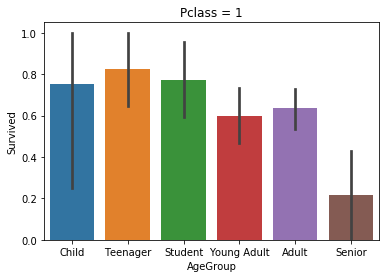

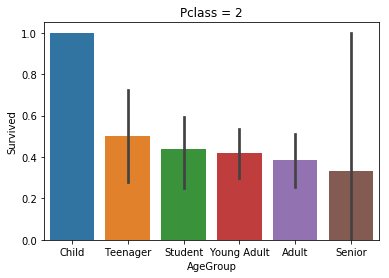

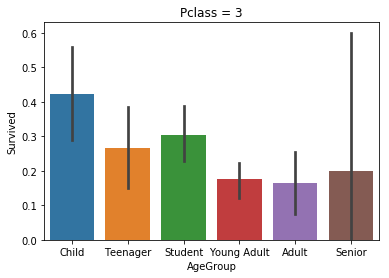

In [1232]:
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

In [1233]:
trData['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [1234]:
pd.qcut(trData['Fare'], 3).value_counts()

(-0.001, 8.662]    308
(26.0, 512.329]    295
(8.662, 26.0]      288
Name: Fare, dtype: int64

In [1235]:
combinedData[['Pclass','Fare']].groupby(['Pclass'], as_index = False).median()

,Pclass,Fare
0,1,60.0000
1,2,15.0458
2,3,8.0500


In [1236]:
trData['Fare'].describe()
fare_bins = [-0.1,  7.5, 15, 40, 70, np.inf]
fare_labels = ['Cheap', 'BelowAverage', 'Average', 'AboveAverage','Expensive']
trData['FareBin'] = pd.cut(trData['Fare'], fare_bins, labels = fare_labels)
testData['FareBin'] = pd.cut(testData['Fare'], fare_bins, labels = fare_labels)

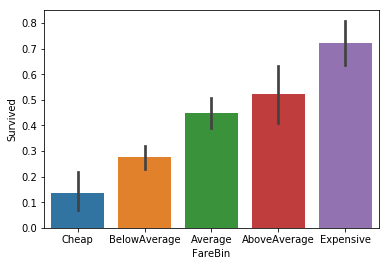

In [1237]:
sns.barplot(x = 'FareBin', y = 'Survived', data = trData)
plt.show()

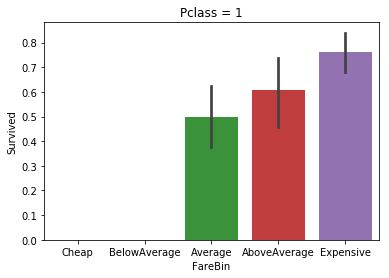

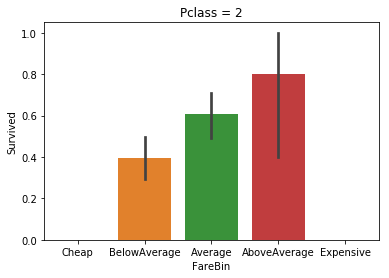

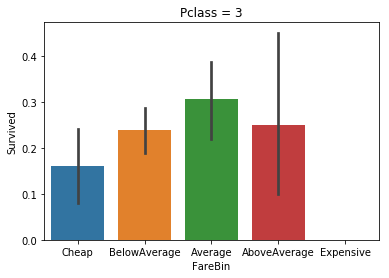

In [1238]:
# Check variation of survival rate vs agegroup within the three Pclasses (this helps picking the right age_bins)
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

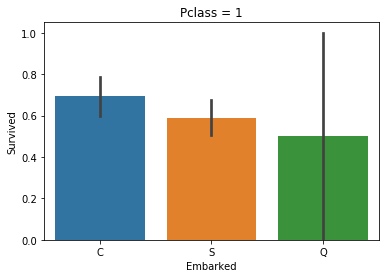

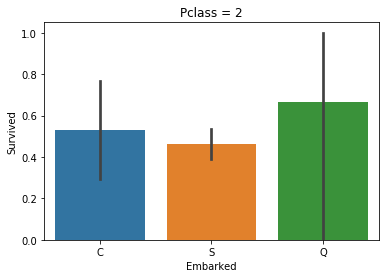

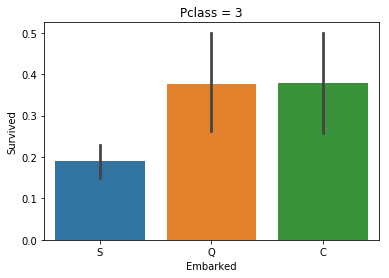

In [1239]:
g = sns.barplot(x = 'Embarked', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'Embarked', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'Embarked', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

In [1240]:
trData['FareBin'].value_counts()

BelowAverage    371
Average         257
Expensive       105
Cheap            87
AboveAverage     71
Name: FareBin, dtype: int64

In [1241]:
TicketVec = []
for data in data_list:
    for i in list(data.Ticket):
        if not i.isdigit() :
            TicketVec.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
        else:
            TicketVec.append("X")
    data["Ticket"] = TicketVec
    data["Ticket"].head()
    TicketVec = []

In [1242]:
trData['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [1243]:
for data in data_list:
    data['TicketPrefix'] = data['Ticket'].apply(lambda x: 'Rare' if data['Ticket'].value_counts()[x] < 6 else x)

In [1244]:
testData['TicketPrefix'].value_counts()

X       296
Rare     63
PC       32
CA       27
Name: TicketPrefix, dtype: int64

In [1245]:
trData['TicketPrefix'].value_counts()

X          661
Rare        71
PC          60
CA          41
A5          21
SOTONOQ     15
STONO       12
WC          10
Name: TicketPrefix, dtype: int64

In [1246]:
testData['Ticket'].value_counts()

X          296
PC          32
CA          27
SOTONOQ      9
SCPARIS      7
A5           7
WC           5
SOPP         4
FCC          4
A4           3
C            3
FC           2
STONO        2
SCAH         2
SOC          2
SCA4         1
A            1
STONO2       1
SC           1
SCParis      1
SOTONO2      1
STONOQ       1
LP           1
SCA3         1
AQ4          1
WEP          1
AQ3          1
PP           1
Name: Ticket, dtype: int64

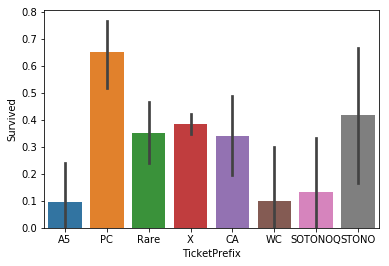

In [1247]:
sns.barplot(x = 'TicketPrefix', y = 'Survived', data = trData)
plt.show()

In [1248]:
label = LabelEncoder()
for data in data_list:
    #data['FareBinCode'] = label.fit_transform(data['FareBin'])
    #data['AgeBinCode'] = label.fit_transform(data['AgeBin']) 
    data['TicketCode'] = label.fit_transform(data['TicketPrefix'])
    data['SexCode'] = data['Sex'].replace(['female', 'male'], [0, 1])
    data['EmbarkedCode'] = data['Embarked'].replace(['S', 'Q', 'C'], [0, 1, 2])
    data['TitleCode'] = data['Title'].replace(['Mr', 'Mrs', 'Miss', 'Master','Royal', 'Rare'], [0, 1, 2, 3, 4, 5])
    data['Nfamily'] = data['Parch'] + data['SibSp']
    data['IsAlone'] = 1
    data.loc[data['Nfamily'] > 0, 'IsAlone'] = 0
    data['AgeGroup'] = data['AgeGroup'].replace(age_labels,[0, 1, 2, 3, 4, 5])
    data['FareBin'] = data['FareBin'].replace(fare_labels, [0, 1, 2, 3, 4])

# Statistical Analysis and feature engineering

In [1249]:
trData[['Nfamily', 'Survived']].groupby(['Nfamily'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Nfamily,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


In [1250]:
trData[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [1251]:
trData[['Sex','Survived']].groupby(['Sex'], as_index = False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [1252]:
trData[['SibSp','Survived']].groupby(['SibSp'], as_index = False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [1253]:
trData['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [1254]:
trData[['Pclass','Fare','Survived']].groupby(['Pclass'], as_index = False).mean()

,Pclass,Fare,Survived
0,1,84.154687,0.629630
1,2,20.662183,0.472826
2,3,13.675550,0.242363


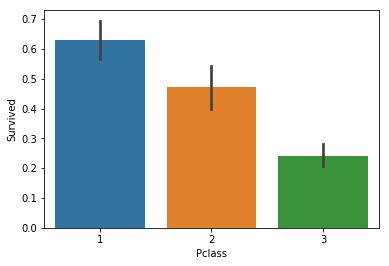

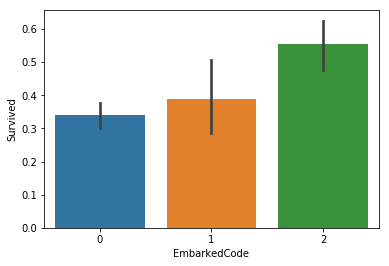

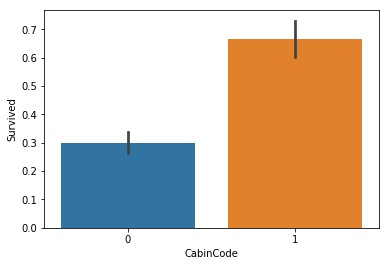

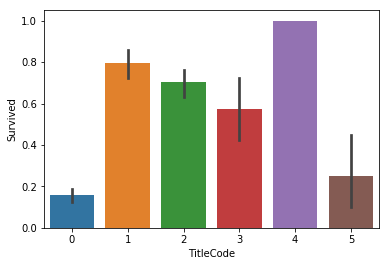

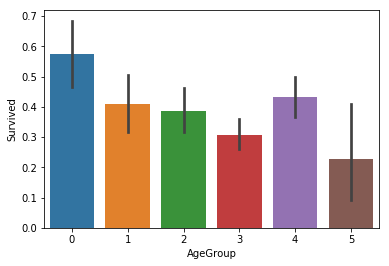

In [1255]:
sns.barplot(x="Pclass", y="Survived", data=trData)
plt.show()
sns.barplot(x="EmbarkedCode", y="Survived", data=trData)
plt.show()
sns.barplot(x = "CabinCode", y = "Survived", data = trData)
plt.show()
sns.barplot(x = "TitleCode", y = "Survived", data = trData)
plt.show()
sns.barplot(x = "AgeGroup", y = "Survived", data = trData)
plt.show()

In [1256]:
pd.crosstab(trData['Sex'], trData['Survived'])

Survived,0,1
Sex,,
female,81,233
male,468,109


In [1257]:
trData[['TitleCode','Survived']].groupby(['TitleCode'], as_index = False).mean()

,TitleCode,Survived
0,0,0.156673
1,1,0.793651
2,2,0.702703
3,3,0.575000
4,4,1.000000
5,5,0.250000


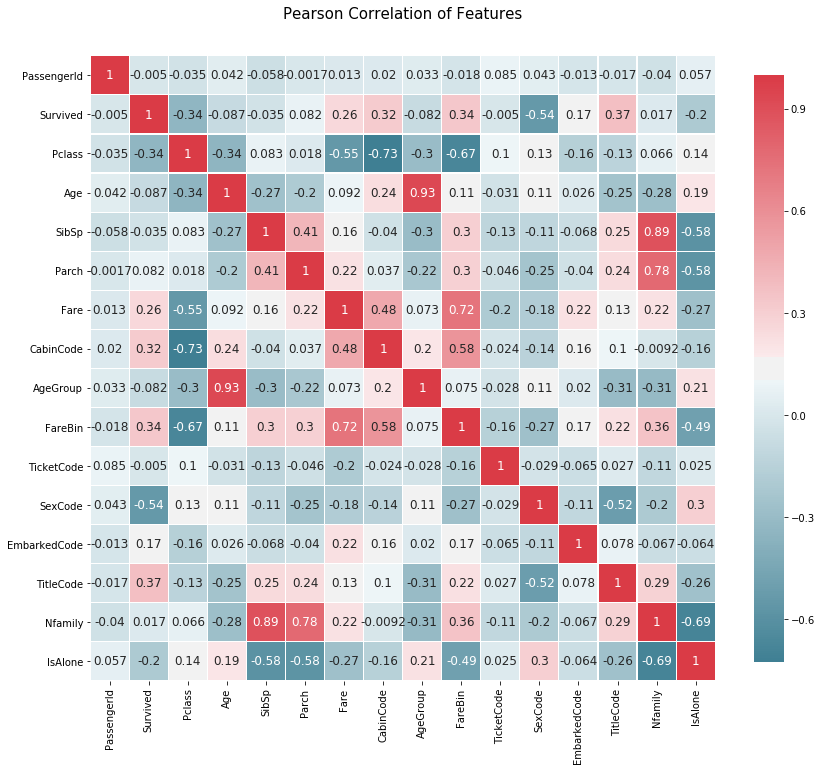

In [1258]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(trData)
plt.show()

# Classification models, cross-validation, and parameter tuning

In [1259]:
selectedFeatures = ['Pclass', 'SexCode', 'AgeGroup', 'TitleCode', 'Nfamily', 'IsAlone', 'EmbarkedCode', 'FareBin'
                    ,'CabinCode', 'TicketCode'];
X = trData[selectedFeatures]
y = trData['Survived']

In [1260]:
X.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin,CabinCode,TicketCode
0,3,1,2,0,1,0,0,0,0,0
1,1,0,4,1,1,0,2,4,1,2
2,3,0,3,2,0,1,0,1,0,3
3,1,0,3,1,1,0,0,3,1,7
4,3,1,3,0,0,1,0,1,0,7


## Cross-validation
First a cross validation; we split the training set (trData) to a test size of 20 percent and train size of 0.8. We do a cross validation on 0.8 set. 

In [1261]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state=1)

In [1262]:
# cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .4, train_size = .6, random_state = 0) 
# grid_bool = [True, False]
# C_param_range = [0.001,0.01,0.1,0.2,1,10,11,12,13,20, 30, 40]
# grid_ratio_list = [.1, .25, .5, .75, 1.0]
# grid_n_neighbors = range(1, 20)
# grid_n_estimator = [10, 50, 100, 300]
# grid_learn = [.01, .03, .05, .1, .25]
# grid_max_depth = [2, 4, 6, 8, 10, None]
# grid_min_samples = [5, 10, .03, .05, .10]
# grid_criterion = ['gini', 'entropy']
# grid_bool = [True, False]
# grid_seed = [0]

# clf_list = [LogisticRegression(), SVC(), ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(), 
#             ensemble.ExtraTreesClassifier(), KNeighborsClassifier()]
# grid_param_list = [[{
#             #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
#             'fit_intercept': grid_bool, #default: True
#             #'penalty': ['l1','l2'],
#             'C': C_param_range,
#             #'solver': ['newton-cg','lbfgs','liblinear']
#              }],
#              [{
#             'C': C_param_range,
#              'gamma': grid_ratio_list
#              }],
#              [{
#               'max_depth': grid_max_depth   
#              }], 
#              [{
#              'n_estimators': grid_n_estimator, #default=10
#              'criterion': grid_criterion, #default=”gini”
#              'max_depth': grid_max_depth, #default=None
#              #'oob_score': [True],
#              'random_state': grid_seed
#              }],
#              [{
#              'n_estimators': grid_n_estimator, #default=10
#              'criterion': grid_criterion, #default=”gini”
#              'max_depth': grid_max_depth, #default=None
#              #'oob_score': [True],
#              'random_state': grid_seed
#              }],
#              [{
#               'n_neighbors': grid_n_neighbors
#              }]
#              ]
# best_scores_list = []
# for clf, param in zip (clf_list, grid_param_list):
#     best_search = model_selection.GridSearchCV(estimator = clf, param_grid = param, cv = cv_split, scoring = 'roc_auc'
#                                               , n_jobs = 4)
#     best_search.fit(Xtrain, ytrain) # Note Xtrain, ytrain NOT X, y
#     best_param = best_search.best_params_
#     best_score = best_search.best_score_
#     print('The best parameter for {} is {} with a runtime of seconds with a score of {}'.format(clf.__class__.__name__, best_param, best_score))
#     clf.set_params(**best_param) 
#     best_scores_list.append(best_score)
# print("--"*45, "\nMax cross-validation score is:", max(best_scores_list))
# print("--"*45, "\nAverage cross-validation score is:", sum(best_scores_list) / len(best_scores_list))

In [1263]:
# i = 4
# clf_list[i].fit(Xtrain, ytrain)
# ypredict = clf_list[i].predict(Xtest)
# score_i = metrics.accuracy_score(ytest, ypredict)
# print(score_i)
# metrics.confusion_matrix(ytest, ypredict)

## From the above results we try a voting 
### Comparing different possible voting lists
We try different voting lists, and pick the one with the highest accuracy. Once we decide about the best voting list, we run the gridsearchCV this time for the whole data set

In [1264]:
# voting_list = [('grBoost', clf_list[2]), ('randforest', clf_list[3]), ('extree', clf_list[4]), ('knn', clf_list[5])]
# # voting_list = [('randforest', clf_list[3]), ('extree', clf_list[4]), ('grBoost', clf_list[2])]
# voting_list = [('a', clf_list[2]), ('c', clf_list[3]), ('d', clf_list[3])]
# votingC = ensemble.VotingClassifier(estimators=voting_list, voting='soft', n_jobs=4)
# votingC = votingC.fit(Xtrain, ytrain)
# arpredict = votingC.predict(Xtest)
# print(metrics.accuracy_score(ytest, arpredict))
# best_voting_list = votingC

The above number is the approximated accuracy that we should when testing the real data. However, of course we should use all the available results for fitting so we replace Xtrain and ytrain with X and y

In [1265]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .4, train_size = .6, random_state = 0) 
grid_bool = [True, False]
C_param_range = [0.001,0.01,0.1,0.2,1,10,11,12,13,20, 30, 40]
grid_ratio_list = [.1, .25, .5, .75, 1.0]
grid_n_neighbors = range(1, 20)
grid_n_estimator = [10, 50, 100, 300]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

clf_list = [LogisticRegression(), SVC(), ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(), 
            ensemble.ExtraTreesClassifier(), KNeighborsClassifier()]
grid_param_list = [[{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'C': C_param_range,
            #'solver': ['newton-cg','lbfgs','liblinear']
             }],
             [{
            'C': C_param_range,
             'gamma': grid_ratio_list
             }],
             [{
              'max_depth': grid_max_depth   
             }], 
             [{
             'n_estimators': grid_n_estimator, #default=10
             'criterion': grid_criterion, #default=”gini”
             'max_depth': grid_max_depth, #default=None
             #'oob_score': [True],
             'random_state': grid_seed
             }],
             [{
             'n_estimators': grid_n_estimator, #default=10
             'criterion': grid_criterion, #default=”gini”
             'max_depth': grid_max_depth, #default=None
             #'oob_score': [True],
             'random_state': grid_seed
             }],
             [{
              'n_neighbors': grid_n_neighbors
             }]
             ]
best_scores_list = []
for clf, param in zip (clf_list, grid_param_list):
    best_search = model_selection.GridSearchCV(estimator = clf, param_grid = param, cv = cv_split, scoring = 'roc_auc'
                                              , n_jobs = 4)
    best_search.fit(X, y) # Note X, y NOT Xtrain, ytrain
    best_param = best_search.best_params_
    best_score = best_search.best_score_
    print('The best parameter for {} is {} with a runtime of seconds with a score of {}'.format(clf.__class__.__name__, best_param, best_score))
    clf.set_params(**best_param) 
    best_scores_list.append(best_score)
print("--"*45, "\nMax cross-validation score is:", max(best_scores_list))
print("--"*45, "\nAverage cross-validation score is:", sum(sorted(best_scores_list, reverse=True)[0:3]) / 3)

The best parameter for LogisticRegression is {'fit_intercept': True, 'C': 1} with a runtime of seconds with a score of 0.8552218904817672
The best parameter for SVC is {'gamma': 0.1, 'C': 1} with a runtime of seconds with a score of 0.8603114688357563
The best parameter for GradientBoostingClassifier is {'max_depth': 4} with a runtime of seconds with a score of 0.8739409210535349
The best parameter for RandomForestClassifier is {'max_depth': 8, 'criterion': 'entropy', 'random_state': 0, 'n_estimators': 300} with a runtime of seconds with a score of 0.8819029154467999
The best parameter for ExtraTreesClassifier is {'max_depth': 8, 'criterion': 'entropy', 'random_state': 0, 'n_estimators': 50} with a runtime of seconds with a score of 0.8757492304117493
The best parameter for KNeighborsClassifier is {'n_neighbors': 10} with a runtime of seconds with a score of 0.8377967969948245
------------------------------------------------------------------------------------------ 
Max cross-validati

In [1266]:
best_voting_list = [('a', clf_list[2]), ('c', clf_list[3]), ('d', clf_list[4])]
votingC = ensemble.VotingClassifier(estimators=best_voting_list, voting='soft', n_jobs=4)
votingC = votingC.fit(X, y) # Note we fit the Whole X, y
arpredict = votingC.predict(Xtest)
print(metrics.accuracy_score(ytest, arpredict))

0.832402234637


In [1267]:
testDataTemp = testData[selectedFeatures]
arPredict = votingC.predict(testDataTemp)

In [1268]:
testDataTemp.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin,CabinCode,TicketCode
0,3,1,3,0,0,1,1,1,0,3
1,3,0,4,1,1,0,0,0,0,3
2,2,1,5,0,0,1,1,1,0,3
3,3,1,3,0,0,1,0,1,0,3
4,3,0,2,1,2,0,0,1,0,3


In [1269]:
yPredict = pd.DataFrame({'PassengerId':testData['PassengerId'], 'Survived': arPredict})
yPredict.to_csv('../predictions.csv', index = False)

In [1270]:
X.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin,CabinCode,TicketCode
0,3,1,2,0,1,0,0,0,0,0
1,1,0,4,1,1,0,2,4,1,2
2,3,0,3,2,0,1,0,1,0,3
3,1,0,3,1,1,0,0,3,1,7
4,3,1,3,0,0,1,0,1,0,7


In [1271]:
testDataTemp.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin,CabinCode,TicketCode
0,3,1,3,0,0,1,1,1,0,3
1,3,0,4,1,1,0,0,0,0,3
2,2,1,5,0,0,1,1,1,0,3
3,3,1,3,0,0,1,0,1,0,3
4,3,0,2,1,2,0,0,1,0,3


In [1272]:
now = pd.read_csv('../predictions.csv')
best = pd.read_csv('../predictions_score79425_4.csv')
print(len(testData.loc[now['Survived'] != best['Survived']]))
testData.loc[now['Survived'] != best['Survived']]

9


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,CabinCode,AgeGroup,FareBin,TicketPrefix,TicketCode,SexCode,EmbarkedCode,TitleCode,Nfamily,IsAlone
18,910,3,"Ilmakangas, Miss. Ida Livija",female,27.000000,1,0,STONO2,7.9250,NaN,...,0,3,1,Rare,2,0,0,2,1,0
34,926,1,"Mock, Mr. Philipp Edmund",male,30.000000,1,0,X,57.7500,C78,...,1,3,3,X,3,1,2,0,1,0
41,933,1,"Franklin, Mr. Thomas Parham",male,32.252151,0,0,X,26.5500,D34,...,1,3,2,X,3,1,0,0,0,1
68,960,1,"Tucker, Mr. Gilbert Milligan Jr",male,31.000000,0,0,X,28.5375,C53,...,1,3,2,X,3,1,2,0,0,1
214,1106,3,"Andersson, Miss. Ida Augusta Margareta",female,38.000000,4,2,X,7.7750,NaN,...,0,4,1,X,3,0,0,2,6,0
313,1205,3,"Carr, Miss. Jeannie",female,37.000000,0,0,X,7.7500,NaN,...,0,4,1,X,3,0,1,2,0,1
335,1227,1,"Maguire, Mr. John Edward",male,30.000000,0,0,X,26.0000,C106,...,1,3,2,X,3,1,0,0,0,1
354,1246,3,"Dean, Miss. Elizabeth Gladys Millvina""""",female,0.170000,1,2,CA,20.5750,NaN,...,0,0,2,CA,0,0,0,2,3,0
392,1284,3,"Abbott, Master. Eugene Joseph",male,13.000000,0,2,CA,20.2500,NaN,...,0,1,2,CA,0,1,0,3,2,0
